In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Getting the data

In [39]:
def get_data(file_path, dir_path, remote_path):
    if file_path.exists():
        print(f"The path '{file_path}' exists.")
    else:
        dir_path.mkdir(parents=True, exist_ok=True)
        print(f"Downloading data from {remote_path}...")
        urllib.request.urlretrieve(remote_path, file_path)
    return pd.read_csv(file_path)

In [40]:
directory_path = Path('data')
file_path = directory_path / 'course_lead_scoring.csv'
data_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

df = get_data(file_path, directory_path, data_url)
df.head()

The path 'data/course_lead_scoring.csv' exists.


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [41]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


## Data preparation

In [43]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [44]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [45]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NA,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NA,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [46]:
## Split the data

In [47]:

df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test= df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

df_full_train = df_full_train.reset_index(drop=True)
df_full_train.converted.value_counts(normalize=True)


def mutual_info_score_converted_score(series):
    return mutual_info_score(series, df_full_train.converted )

mi = df_full_train[categorical].apply(mutual_info_score_converted_score)

mi.sort_values(ascending=False)

lead_source          0.024562
employment_status    0.012690
industry             0.008173
location             0.001212
dtype: float64

In [48]:
# Training set 
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)

# Validation set 
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(x_train, y_train)

# Calculate predictions and accuracy
y_pred = model.predict_proba(x_val)[:, 1]
churn_decision = (y_pred >= 0.5)
accuracy = (y_val == churn_decision).mean()

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.70


In [49]:
def train_and_evaluate(features_to_use):
    # Prepare training data
    train_dicts = df_train[features_to_use].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    
    # Prepare validation data
    val_dicts = df_val[features_to_use].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    
    # Calculate accuracy
    y_pred = model.predict_proba(X_val)[:, 1]
    predictions = (y_pred >= 0.5).astype(int)
    accuracy = (y_val == predictions).mean()
    
    return accuracy

In [50]:
# Train baseline model with all features
print("Training baseline model with all features...")
baseline_accuracy = train_and_evaluate( categorical + numerical)
print(f"Baseline accuracy (all features): {baseline_accuracy:.6f}\n")

Training baseline model with all features...
Baseline accuracy (all features): 0.699659



In [51]:
results = []
for feature_to_remove in (categorical + numerical):
    # Create feature list without current feature
    features_subset = [f for f in (categorical + numerical) if f != feature_to_remove]
    
    # Train model without this feature
    accuracy_without = train_and_evaluate(features_subset)
    
    # Calculate difference (baseline - without_feature)
    # Positive difference means the feature is useful (accuracy drops without it)
    # Negative difference means the feature is harmful (accuracy improves without it)
    difference = baseline_accuracy - accuracy_without
    
    results.append({
        'feature': feature_to_remove,
        'accuracy_without': accuracy_without,
        'difference': difference
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('difference', ascending=True)
print(results_df.to_string(index=False))
print()
print()
print()
least_useful_feature = results_df.loc[results_df['difference'].abs().idxmin()]
print("Least useful feature (smallest absolute difference):")
print()
print(least_useful_feature)
print(f"\nFeature name: {least_useful_feature['feature']}")
print(f"Difference: {least_useful_feature['difference']}")

                 feature  accuracy_without  difference
           annual_income          0.846416   -0.146758
             lead_source          0.703072   -0.003413
       employment_status          0.703072   -0.003413
                industry          0.699659    0.000000
                location          0.699659    0.000000
              lead_score          0.699659    0.000000
       interaction_count          0.587031    0.112628
number_of_courses_viewed          0.583618    0.116041



Least useful feature (smallest absolute difference):

feature             industry
accuracy_without    0.699659
difference               0.0
Name: 1, dtype: object

Feature name: industry
Difference: 0.0


In [52]:
def accuracy_training (c_value):  
    # Training set 
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(train_dicts)
    
    # Validation set 
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    x_val = dv.transform(val_dicts)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=c_value, max_iter=1000, random_state=1)
    model.fit(x_train, y_train)
    
    # Calculate predictions and accuracy
    y_pred = model.predict_proba(x_val)[:, 1]
    churn_decision = (y_pred >= 0.5)
    accuracy = (y_val == churn_decision).mean()

    return {
        'c_value': c_value,
        'accuracy': round(accuracy,3)
    }

In [53]:
accuracy_results = []

c_value_list = [0.01, 0.1, 1, 10, 100]
for c in c_value_list:
    result = accuracy_training(c)
    accuracy_results.append(result)

In [54]:
accuracy_results_df = pd.DataFrame(accuracy_results)

accuracy_results_df = accuracy_results_df.sort_values(
    by=['accuracy', 'c_value'], 
    ascending=[False, True]
)
print("\n" + "=" * 40)
print("Results sorted by accuracy (best first):")
print(accuracy_results_df.to_string(index=False))


Results sorted by accuracy (best first):
 c_value  accuracy
    0.01       0.7
    0.10       0.7
    1.00       0.7
   10.00       0.7
  100.00       0.7


In [73]:
# Question 1: Calculate ROC AUC for each numerical variable
print("Question 1: ROC AUC Feature Importance")
print("=" * 50)

auc_scores = {}

for feature in numerical:
    # Use the feature values as prediction scores
    predictions = df_train[feature].values
    
    # Calculate AUC
    auc = roc_auc_score(y_train, predictions)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -predictions)
        print(f"{feature:30s}: {auc:.6f} (inverted)")
    else:
        print(f"{feature:30s}: {auc:.6f}")
    
    auc_scores[feature] = auc

print("=" * 50)

# Find the feature with highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_feature]

print(f"\nHighest AUC: {best_feature}")
print(f"AUC Score: {best_auc:.6f}")

Question 1: ROC AUC Feature Importance
number_of_courses_viewed      : 0.763568
annual_income                 : 0.551958
interaction_count             : 0.738270
lead_score                    : 0.614499

Highest AUC: number_of_courses_viewed
AUC Score: 0.763568


In [88]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [90]:
# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(x_train, y_train)

# Get predictions (probabilities)
y_pred_proba = model.predict_proba(x_val)[:, 1]

# Calculate ROC AUC
model_auc = roc_auc_score(y_val, y_pred_proba)

print(f"\nModel ROC AUC Score: {model_auc:.2f}")


Model ROC AUC Score: 0.82


In [93]:
y_pred = (y_pred_proba >= 0.5).astype(int)
accuracy = (y_val == y_pred).mean()
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.70


In [117]:
actual_positive =(y_val == 1)
actual_negative =(y_val == 0)

t = 0.5
predict_pos = (y_pred >= t)
predict_neg = (y_pred < t)

tp = (predict_pos & actual_positive).sum()
tn = (predict_neg & actual_negative).sum()

fp = (predict_pos & actual_negative).sum()
fn = (predict_neg & actual_positive).sum()

In [119]:
precision = tp/ (tp + fp)
precision

0.6693877551020408

In [123]:
recall = tp / (tp + fn)
recall

0.9590643274853801

In [127]:
from sklearn.metrics import roc_curve
fpr, tpr, threasholds = roc_curve(y_val, y_pred)

Text(0, 0.5, 'TPR')

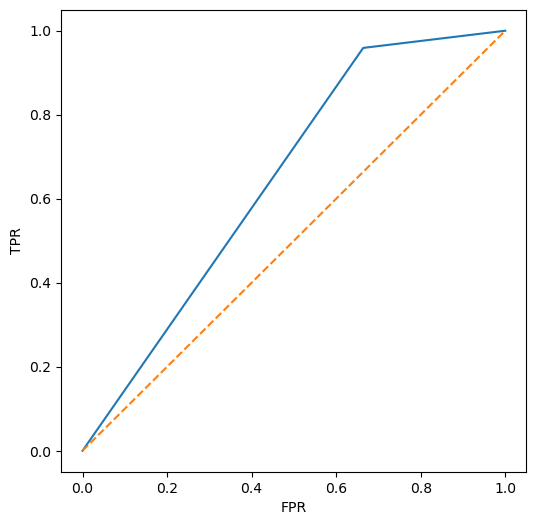

In [137]:
plt.figure(figsize = (6,6))
plt.plot(fpr, tpr, label = 'Model')
plt.plot([0,1], [0,1], label = 'Random',  linestyle = '--')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [139]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.647564950627936

(0.0, 1.0)

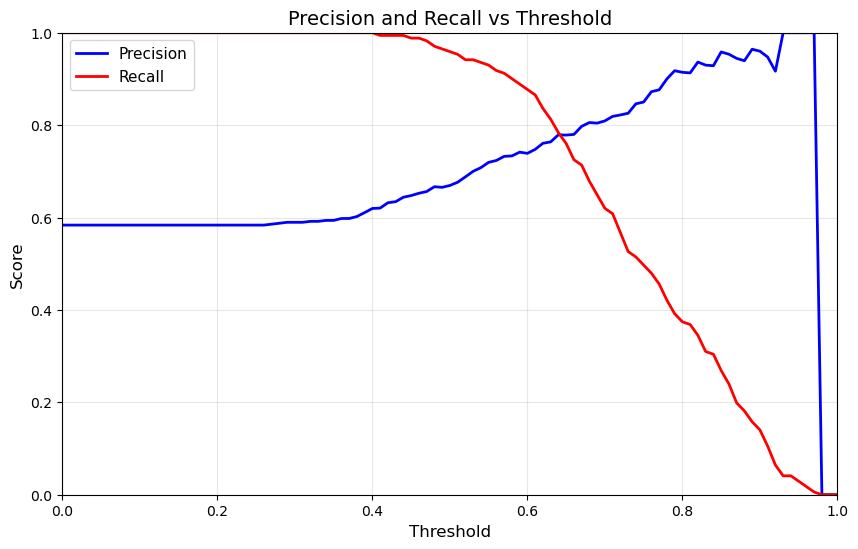

In [143]:
# Create thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Calculate precision and recall for each threshold
for t in thresholds:
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_pred_proba >= t).astype(int)
    
    # Calculate confusion matrix elements
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_pos = (y_pred == 1)
    predict_neg = (y_pred == 0)
    
    tp = (predict_pos & actual_positive).sum()
    fp = (predict_pos & actual_negative).sum()
    fn = (predict_neg & actual_positive).sum()
    
    # Calculate precision and recall
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2, color='blue')
plt.plot(thresholds, recalls, label='Recall', linewidth=2, color='red')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

Best F1 Score: 0.8125
At threshold: 0.570

Given options and their closest match:
  0.14: difference = 0.6725
  0.34: difference = 0.4725
  0.54: difference = 0.2725
  0.74: difference = 0.0725

Closest option: 0.74


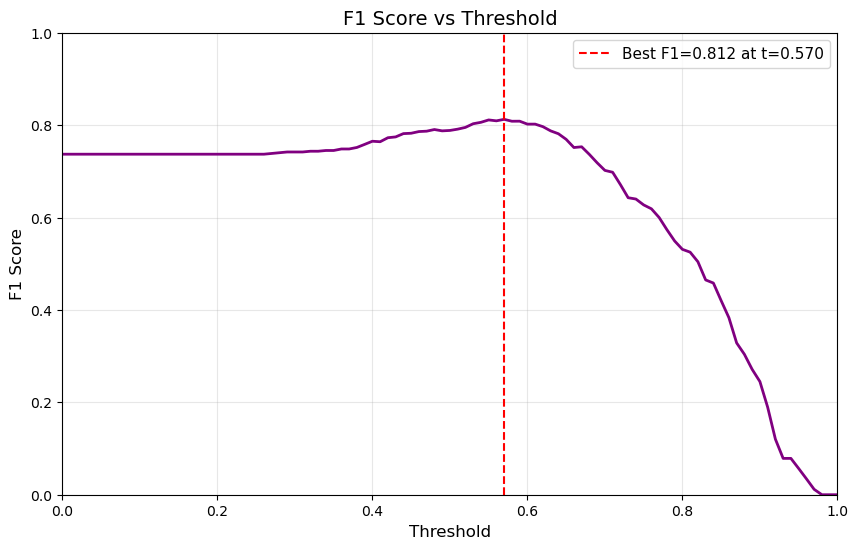


Question 5: 5-Fold Cross-Validation Standard Deviation
5-Fold CV ROC AUC Scores: [0.80607459 0.87137384 0.77543201 0.80183686 0.85582727]
Mean: 0.8221
Standard Deviation: 0.0358

Given options and their difference from calculated std:
  0.0001: difference = 0.035707
  0.006: difference = 0.029807
  0.06: difference = 0.024193
  0.36: difference = 0.324193

Closest option: 0.06

Question 6: Best C Parameter
C=  0.000001 | Mean ROC AUC: 0.5602 | Std: 0.0238
C=  0.001000 | Mean ROC AUC: 0.8669 | Std: 0.0287
C=  0.010000 | Mean ROC AUC: 0.8313 | Std: 0.0343
C=  0.100000 | Mean ROC AUC: 0.8230 | Std: 0.0354
C=  1.000000 | Mean ROC AUC: 0.8221 | Std: 0.0358
C= 10.000000 | Mean ROC AUC: 0.8220 | Std: 0.0358
C=100.000000 | Mean ROC AUC: 0.8220 | Std: 0.0358

Best C: 0.001
Best mean ROC AUC: 0.8669

Scores for given options:
  C=1e-06: ROC AUC = 0.5602
  C=0.001: ROC AUC = 0.8669
  C=1: ROC AUC = 0.8221

SUMMARY OF ANSWERS
Question 4 (F1 Score): 0.74
Question 5 (5-Fold CV Std): 0.06
Question 6

In [151]:

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score
# Calculate F1 scores for all thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find the best F1 score
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"Best F1 Score: {best_f1_score:.4f}")
print(f"At threshold: {best_f1_threshold:.3f}")

# Check the given options
f1_options = [0.14, 0.34, 0.54, 0.74]
print(f"\nGiven options and their closest match:")
for opt in f1_options:
    diff = abs(opt - best_f1_score)
    print(f"  {opt}: difference = {diff:.4f}")

best_option_f1 = min(f1_options, key=lambda x: abs(x - best_f1_score))
print(f"\nClosest option: {best_option_f1}")

# Plot F1 score vs threshold
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, color='purple')
plt.axvline(x=best_f1_threshold, color='red', linestyle='--', 
            label=f'Best F1={best_f1_score:.3f} at t={best_f1_threshold:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

print("\n" + "="*60)
print("Question 5: 5-Fold Cross-Validation Standard Deviation")
print("="*60)

# Prepare the full training data
df_full_train_copy = df_full_train.copy()
y_full_train = df_full_train_copy.converted.values
df_full_train_copy = df_full_train_copy.drop('converted', axis=1)

# Prepare features
train_dicts_full = df_full_train_copy[categorical + numerical].to_dict(orient='records')
dv_cv = DictVectorizer(sparse=False)
X_full_train = dv_cv.fit_transform(train_dicts_full)

# Perform 5-Fold Cross-Validation with C=1.0
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)

# Get cross-validation scores (using ROC AUC)
cv_scores = cross_val_score(model_cv, X_full_train, y_full_train, 
                            cv=kfold, scoring='roc_auc')

cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"5-Fold CV ROC AUC Scores: {cv_scores}")
print(f"Mean: {cv_mean:.4f}")
print(f"Standard Deviation: {cv_std:.4f}")

# Check the given options
std_options = [0.0001, 0.006, 0.06, 0.36]
print(f"\nGiven options and their difference from calculated std:")
for opt in std_options:
    diff = abs(opt - cv_std)
    print(f"  {opt}: difference = {diff:.6f}")

best_option_std = min(std_options, key=lambda x: abs(x - cv_std))
print(f"\nClosest option: {best_option_std}")

print("\n" + "="*60)
print("Question 6: Best C Parameter")
print("="*60)

# Test different C values including the new options
c_values = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100]
results = []

for c in c_values:
    # Perform 5-fold CV for each C
    model_c = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=1)
    scores = cross_val_score(model_c, X_full_train, y_full_train, 
                            cv=kfold, scoring='roc_auc')
    mean_score = scores.mean()
    std_score = scores.std()
    
    results.append({
        'C': c,
        'mean_roc_auc': mean_score,
        'std_roc_auc': std_score
    })
    
    print(f"C={c:10.6f} | Mean ROC AUC: {mean_score:.4f} | Std: {std_score:.4f}")

# Find best C
results_df = pd.DataFrame(results)
best_c_idx = results_df['mean_roc_auc'].idxmax()
best_c = results_df.loc[best_c_idx, 'C']
best_score = results_df.loc[best_c_idx, 'mean_roc_auc']

print(f"\nBest C: {best_c}")
print(f"Best mean ROC AUC: {best_score:.4f}")

# Check given options
c_options = [0.000001, 0.001, 1]
print(f"\nScores for given options:")
for c_opt in c_options:
    if c_opt in results_df['C'].values:
        row = results_df[results_df['C'] == c_opt].iloc[0]
        print(f"  C={c_opt}: ROC AUC = {row['mean_roc_auc']:.4f}")

print("\n" + "="*60)
print("SUMMARY OF ANSWERS")
print("="*60)
print(f"Question 4 (F1 Score): {best_option_f1}")
print(f"Question 5 (5-Fold CV Std): {best_option_std}")
print(f"Question 6 (Best C): {best_c}")
print("="*60)
